In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization, Dropout
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import utils

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
not_normal = load_images_from_folder("NOT_NORMAL")
normal = load_images_from_folder("NORMAL")

In [4]:
print(str(len(not_normal)/len(normal)) + " Is the rate of two categories ")

0.1 Is the rate of two categories 


In [5]:
#Data has imblance issue, 
#applying oversampeling method on not_normal 

In [6]:
not_normal[0].shape

(650, 1028, 3)

In [7]:
normal[0].shape

(1317, 1857, 3)

In [8]:
#difference in shape need to deal with

In [9]:
for img in normal:
    img = cv.resize(img, (1028,650))

In [10]:
normal_resized = [cv.resize(img, (1028,650)) for img in normal]
not_normal_resized = [cv.resize(img, (1028,650)) for img in not_normal]

In [11]:
normal_resized[0].shape

(650, 1028, 3)

In [12]:
generator = ImageDataGenerator(rotation_range=10 , brightness_range=[0.6,1.4], zoom_range=[0.8,1.2], horizontal_flip=True, height_shift_range=None,
                               width_shift_range=None)

In [13]:
def aug_all(list):
    all_images =[]
    i=1
    for img in list:
        aug_iter = generator.flow(np.expand_dims(img,0))
        #generate 10 of each image
        aug_image = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
        all_images.extend(aug_image)
        print(i)
        i+=1
    return(all_images)        

In [14]:
not_normal_aug = aug_all(not_normal_resized)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [15]:
len(not_normal_aug)


600

In [16]:
not_normal_aug[0].shape

(650, 1028, 3)

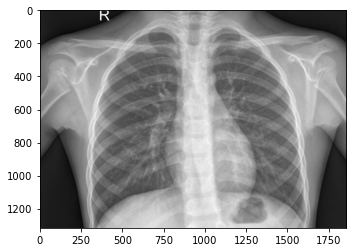

In [17]:
plt.imshow(normal[0])

In [18]:
train_X = normal_resized + not_normal_aug

In [19]:
train_X[0].shape

(650, 1028, 3)

In [20]:
len(normal_resized), len(not_normal_aug)

(600, 600)

In [21]:
#generate label for data
#[[1,0]] normal label, [[0,1]] not_normal label 
a = np.array([[1,0]]*600)
b = np.array([[0,1]]*600)

In [22]:
train_Y = np.row_stack((a,b))

In [23]:
train_Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [24]:
#shuffle datatrai
trainX, trainy = shuffle(train_X, train_Y, random_state=42)

(<matplotlib.image.AxesImage at 0x257835b7850>, array([0, 1]))

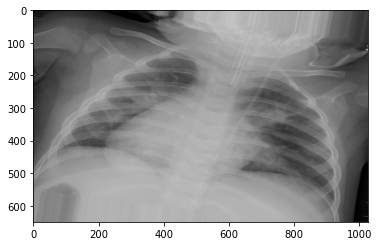

In [25]:
plt.imshow(trainX[0]), trainy[0]

In [26]:
train_X_arr = np.stack(trainX)
trainy.shape, train_X_arr.shape # correct shape for model 
# data in ready for training

((1200, 2), (1200, 650, 1028, 3))

In [27]:
print("Tensorflow-version:", tf.__version__)

Tensorflow-version: 2.6.0


In [48]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(650, 1028, 3))

In [49]:
x=model_d.output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

In [50]:
preds=Dense(2,activation='softmax')(x)

In [51]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 650, 1028, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 656, 1034, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 325, 514, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 325, 514, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [52]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [53]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 650, 1028, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 656, 1034, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 325, 514, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 325, 514, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [54]:
(xtrain,xtest,ytrain,ytest)=train_test_split(train_X_arr,trainy,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape,ytrain.shape,ytest.shape)

(960, 650, 1028, 3) (240, 650, 1028, 3) (960, 2) (240, 2)


In [55]:
xtrain = xtrain/255
xtest = xtest/255

In [36]:
# anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [56]:
history = model.fit(xtrain, ytrain, batch_size=128,epochs=1)

8/8 [==============================] - 403s 49s/step - loss: 0.3612 - accuracy: 0.8604


In [57]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3161264235055668371
]


In [ ]:
Ypred = model.predict(xtest)

In [43]:
Ypred = np.argmax(Ypred, axis=1)

In [44]:
Ytrue = np.argmax(ytest, axis=1)

Text(0.5, 144.41374999999996, 'Predicted')

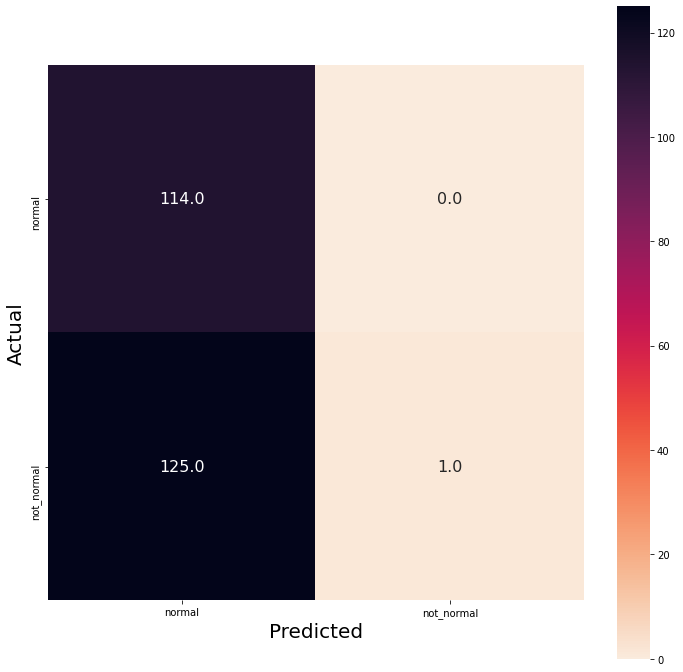

In [46]:
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=["normal","not_normal"], 
                 yticklabels=["normal","not_normal"])
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [47]:
del model_d